In [ ]:
import os, sys

sys.path.append(os.path.abspath(os.path.join("../..")))  # access sibling directories

from src.python.helpers import load_empirical_rt_data, join_and_fill_missings
from src.python.settings import plotting_settings, plotting_update

import pickle
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
plt.rcParams.update(plotting_update)

# Simulated vs. empirical RTs

## Load data

In [3]:
# Empirical data
parent_folder = os.path.dirname(os.path.dirname(os.getcwd()))
color_folder = os.path.join(
    parent_folder, "data/levy_comparison/data_rts/color"
)
lexical_folder = os.path.join(
    parent_folder, "data/levy_comparison/data_rts/lexical"
)

color_data = load_empirical_rt_data(color_folder)
lexical_data = load_empirical_rt_data(lexical_folder)

# Join experimental data and fill missing values
empirical_data = join_and_fill_missings(
    color_data, lexical_data, n_trials=900, missing_rts_equal_mean=True
)

In [4]:
# Simulated data, powerscaled
# Use validate set here to reduce sns.kdeplot computation time 
#path = "../../data/levy_comparison/sim_powerscaled/test.pkl"
path = "../../data/levy_comparison/sim_powerscaled/validate.pkl"
with open(path, "rb") as file:
    test_data_scaled = pickle.load(file)

## Plot

### RT distribution per person

In [5]:
# Recode simulated & empirical data so that negative RTs represent the lower decision boundary
sim_dict = test_data_scaled["model_outputs"].copy()
for model in range(4):
    sim_dict[model]["sim_data"][..., 1][sim_dict[model]["sim_data"][..., 2] == 0] = -sim_dict[model]["sim_data"][..., 1][sim_dict[model]["sim_data"][..., 2] == 0]

emp_data = empirical_data.copy()
emp_data[..., 1][emp_data[..., 2] == 0] = -emp_data[..., 1][emp_data[..., 2] == 0]

In [42]:
import matplotlib.patches as mpatches

In [56]:
(4*60+43)/55

5.1454545454545455

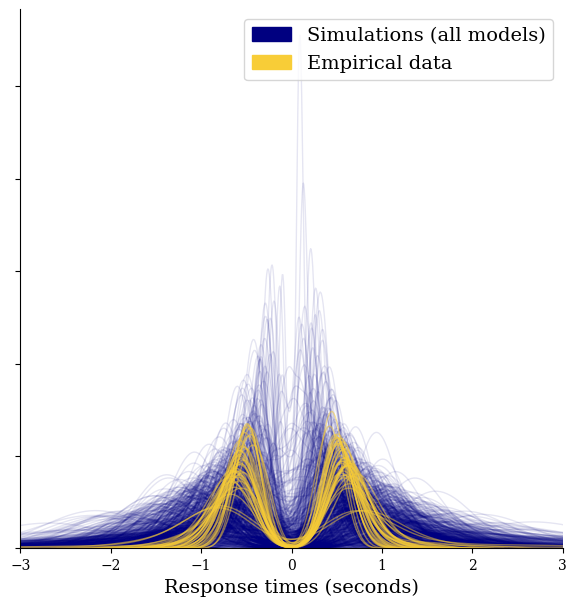

In [54]:
# Plot (takes 50 sec for all 100 data sets from validate.pkl; 8 sec for 20 data sets)
N_SIMULATED_DATA_SETS_PLOTTED_PER_MODEL = 5  # too many make the plot too cluttered

fig, ax = plt.subplots(1, 1, figsize=(7, 7))
# colors = [
#     "#440154",
#     "#3b528b",
#     "#21918c",
#     "#5ec962",
#     "#fde725"
# ]
# labels = [
#     "$\mathcal{M}_1$", 
#     "$\mathcal{M}_2$", 
#     "$\mathcal{M}_3$", 
#     "$\mathcal{M}_4$"
#     ]

colors = ["#000080", "#f8cd37"]  # same as in alpha prior predictive plot
labels = ["Simulations (all models)", "Empirical data"]

sim_shape = sim_dict[model]["sim_data"].shape

for model in range(4):
    for dataset in range(N_SIMULATED_DATA_SETS_PLOTTED_PER_MODEL):
        for person in range(sim_shape[1]):
            sns.kdeplot(sim_dict[model]["sim_data"][dataset, person, :, 1], color=colors[0], alpha=0.1, linewidth=1)
for person in range(sim_shape[1]):
    sns.kdeplot(emp_data[0, person, :, 1], color=colors[1], alpha=0.5, linewidth=1)

sns.despine()
ax.set_xlim(-3, 3)
ax.set_xlabel("Response times (seconds)", fontsize=14)
ax.set_ylabel("")
ax.tick_params(axis='x', labelsize=10)
ax.set_yticklabels([])

# Create patches for the legend
patches = [mpatches.Patch(color=color, label=label) for color, label in zip(colors, labels)]

# Add the legend to the plot
plt.legend(handles=patches, fontsize=14, loc="upper right")

plt.savefig("../../figures/levy_pushforward_person_rts.pdf", dpi=300, bbox_inches="tight")

### Full RT distribution without distinction between persons

In [ ]:
# Recode simulated & empirical data so that negative RTs represent the lower decision boundary (flattened output)
sim_rts = []

for model in range(4):
    sim_data = test_data_scaled["model_outputs"][model]["sim_data"].copy()
    sim_data[..., 1][sim_data[..., 2] == 0] = -sim_data[..., 1][sim_data[..., 2] == 0]
    sim_rts.append(sim_data[..., 1].flatten())

emp_data = empirical_data.copy()
emp_data[..., 1][emp_data[..., 2] == 0] = -emp_data[..., 1][emp_data[..., 2] == 0]
emp_rts = emp_data[..., 1].flatten()

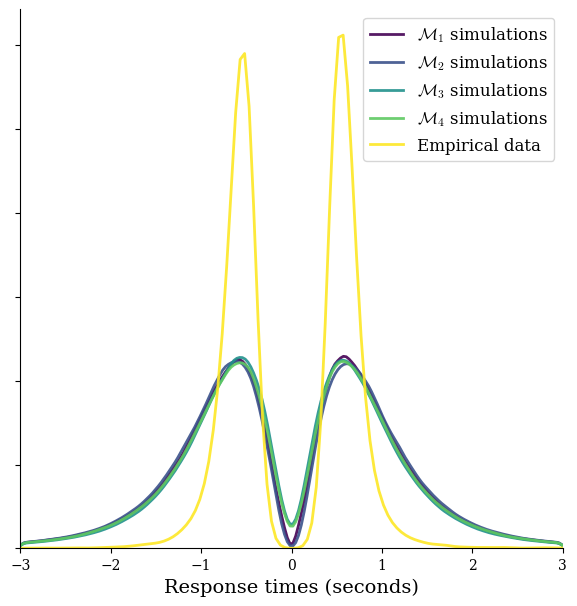

In [8]:
# Plot (takes 30min for 8k data sets from test.pkl)
fig, ax = plt.subplots(1, 1, figsize=(7, 7))
colors = [
    "#440154",
    "#3b528b",
    "#21918c",
    "#5ec962",
    "#fde725"
]
labels = [
    "$\mathcal{M}_1$", 
    "$\mathcal{M}_2$", 
    "$\mathcal{M}_3$", 
    "$\mathcal{M}_4$"
    ]


for model in range(4):
    filtered_sim_rts = sim_rts[model][(sim_rts[model] > -3) & (sim_rts[model] < 3)]  # Filter for smoother KDEs
    sns.kdeplot(filtered_sim_rts, color=colors[model], alpha=0.9, linewidth=2, label=f"{labels[model]} simulations")
    #sns.kdeplot(sim_rts[model], color=colors[model], alpha=0.9, linewidth=2, label=f"{labels[model]} simulations")
sns.kdeplot(emp_rts, color=colors[4], alpha=0.9, linewidth=2, label='Empirical data')
sns.despine()

ax.set_xlim(-3, 3)
ax.set_xlabel("Response times (seconds)", fontsize=14)
ax.set_ylabel("")
ax.tick_params(axis='x', labelsize=10)
ax.set_yticklabels([])
ax.legend(loc="upper right", fontsize=12)

plt.savefig("../../figures/levy_pushforward_rts.pdf", dpi=300, bbox_inches="tight")